## Neural ODE

Generated 1000 samples and saved to pendulum_train.csv


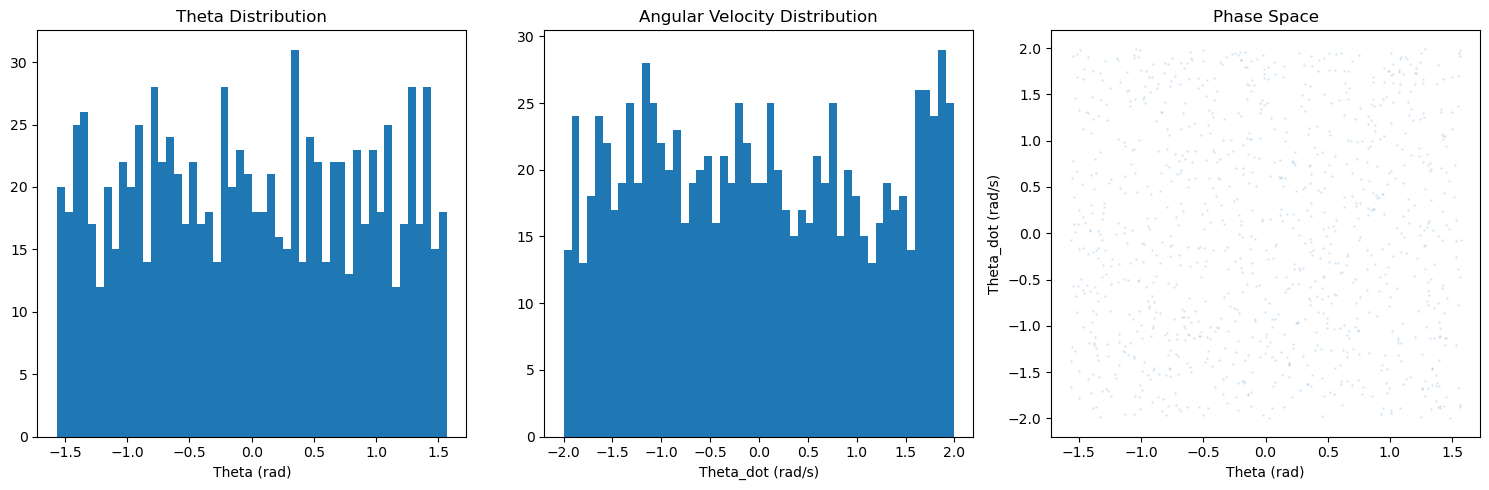

Generated 1000 samples and saved to pendulum_test.csv


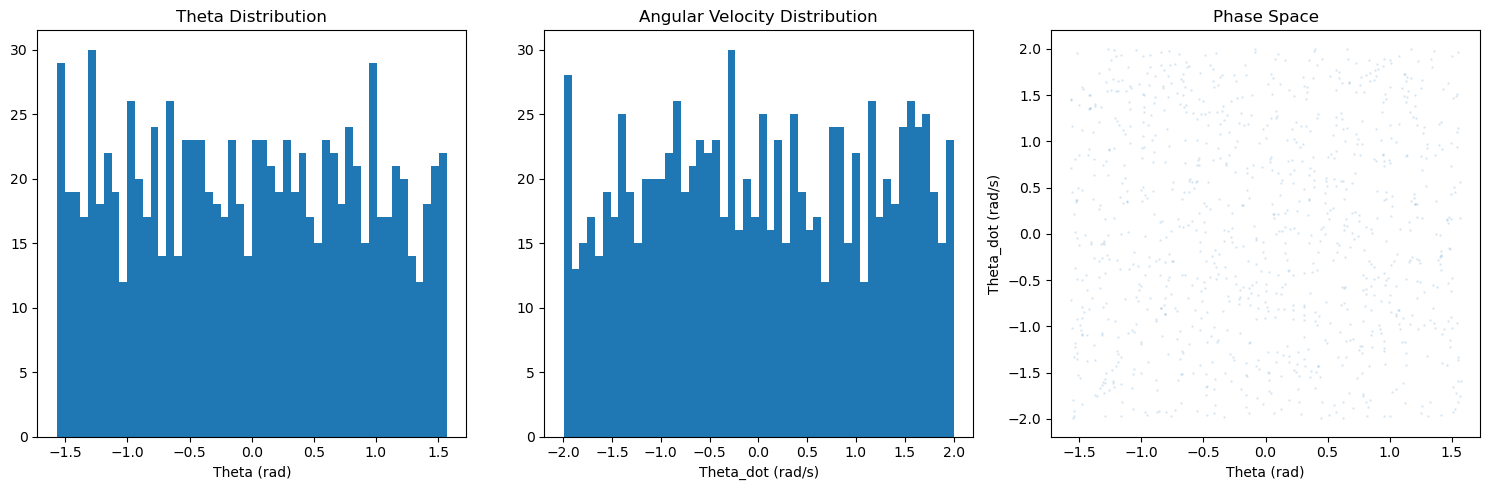


Training Dataset Statistics:
             theta    theta_dot      control   theta_next  theta_dot_next
count  1000.000000  1000.000000  1000.000000  1000.000000     1000.000000
mean     -0.007058     0.001817    -0.007890    -0.007011        0.002818
std       0.903213     1.168873     0.579310     0.902824        1.168373
min      -1.564972    -1.997035    -0.998503    -1.590624       -2.178955
25%      -0.774411    -1.026903    -0.499810    -0.773115       -0.993660
50%      -0.021604    -0.039369    -0.004702    -0.019158       -0.051045
75%       0.761550     1.008526     0.497493     0.760362        0.984905
max       1.567001     1.992192     0.999452     1.602169        2.180556

Average change in one timestep:
Theta: 0.000046 ± 0.023336
Theta_dot: 0.001000 ± 0.139575


In [21]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_pendulum_dataset(n_samples=200, t_span=[0, 1], dt=0.02, output_file="pendulum_dataset.csv"):
    """
    Generate pendulum data and save to CSV.
    CSV format: theta, theta_dot, control, theta_next, theta_dot_next
    """
    t = np.arange(t_span[0], t_span[1], dt)
    
    def pendulum_dynamics(state, control=0.0, L=1.0, g=9.81, m=1.0, b=0.1):
        theta, omega = state
        dtheta = omega
        domega = (-b*omega - m*g*L*np.sin(theta) + control)/(m*L**2)
        return np.array([dtheta, domega])
    
    # Lists to store data
    data = []
    
    # Generate multiple trajectories
    for _ in range(n_samples):
        # Random initial conditions
        theta0 = np.random.uniform(-np.pi/2, np.pi/2)
        omega0 = np.random.uniform(-2, 2)
        state = np.array([theta0, omega0])
        
        # Random control input (optional)
        control = np.random.uniform(-1, 1)
        
        # Generate one step data using RK4
        k1 = pendulum_dynamics(state, control)
        k2 = pendulum_dynamics(state + dt*k1/2, control)
        k3 = pendulum_dynamics(state + dt*k2/2, control)
        k4 = pendulum_dynamics(state + dt*k3, control)
        
        # Update state
        next_state = state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
        
        # Store the data point
        data.append([state[0], state[1], control, next_state[0], next_state[1]])
    
    # Convert to DataFrame and save
    df = pd.DataFrame(data, columns=['theta', 'theta_dot', 'control', 'theta_next', 'theta_dot_next'])
    df.to_csv(output_file, index=False)
    
    print(f"Generated {n_samples} samples and saved to {output_file}")
    
    # Visualize some examples
    plt.figure(figsize=(15, 5))
    
    # Plot theta distribution
    plt.subplot(131)
    plt.hist(df['theta'], bins=50)
    plt.title('Theta Distribution')
    plt.xlabel('Theta (rad)')
    
    # Plot theta_dot distribution
    plt.subplot(132)
    plt.hist(df['theta_dot'], bins=50)
    plt.title('Angular Velocity Distribution')
    plt.xlabel('Theta_dot (rad/s)')
    
    # Plot phase space
    plt.subplot(133)
    plt.scatter(df['theta'], df['theta_dot'], alpha=0.1, s=1)
    plt.title('Phase Space')
    plt.xlabel('Theta (rad)')
    plt.ylabel('Theta_dot (rad/s)')
    
    plt.tight_layout()
    plt.show()
    
    return df

if __name__ == "__main__":
    # Generate training dataset
    train_df = generate_pendulum_dataset(n_samples=1000, dt=0.02, output_file="pendulum_train.csv")
    
    # Generate test dataset with different initial conditions
    test_df = generate_pendulum_dataset(n_samples=1000, dt=0.02, output_file="pendulum_test.csv")
    
    # Print some statistics
    print("\nTraining Dataset Statistics:")
    print(train_df.describe())
    
    # Verify data consistency
    theta_diff = train_df['theta_next'] - train_df['theta']
    theta_dot_diff = train_df['theta_dot_next'] - train_df['theta_dot']
    
    print("\nAverage change in one timestep:")
    print(f"Theta: {theta_diff.mean():.6f} ± {theta_diff.std():.6f}")
    print(f"Theta_dot: {theta_dot_diff.mean():.6f} ± {theta_dot_diff.std():.6f}")

In [33]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class ODEFunc(nn.Module):
    def __init__(self, hidden_dim=32, control_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
    
    def forward(self, t, y, u):

        if y.dim() == 1:
            y = y.unsqueeze(0)  # (1,2)
        if u.dim() == 1:
            u = u.unsqueeze(0)  # (1,control_dim)

         # Concatenate y and u along last dim
        inp = torch.cat([y, u], dim=-1)  # shape (batch_size, 2+control_dim)
        
        # Pass through the network
        out = self.net(inp)  # shape (batch_size, 2)
        
        # If we started with unbatched data, squeeze back
        if out.shape[0] == 1:
            out = out.squeeze(0)
        return out

def rk4_step(func, t, y, dt, u):
    k1 = func(t, y, u)
    k2 = func(t + dt/2, y + dt*k1/2, u)
    k3 = func(t + dt/2, y + dt*k2/2, u)
    k4 = func(t + dt, y + dt*k3, u)
    return y + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

class NeuralODE(nn.Module):
    def __init__(self):
        super().__init__()
        self.func = ODEFunc()
    
    def forward(self, y0, t, dt):
        y = y0
        trajectory = [y]
        
        for i in range(len(t)-1):
            y = rk4_step(self.func, t[i], y, dt)
            trajectory.append(y)
        
        return torch.stack(trajectory, dim=1)
    
class NeuralODE(nn.Module):
    def __init__(self, hidden_dim=32, control_dim=1):
        super().__init__()
        self.func = ODEFunc(hidden_dim, control_dim)
    
    def forward(self, y0, t, dt, controls):
        if y0.dim() == 1:
            y0 = y0.unsqueeze(0)  # -> (1,2)
        
        if controls.dim() == 2:
            controls = controls.unsqueeze(0)
        
        y = y0
        trajectory = [y]
        
        for i in range(len(t) - 1):
            u_i = controls[:, i, :]
            new_states = []
            for batch_idx in range(y.shape[0]):
                y_single = y[batch_idx]
                u_single = u_i[batch_idx]
                y_new = rk4_step(self.func, t[i], y_single, dt, u_single)
                new_states.append(y_new.unsqueeze(0))
            
            y = torch.cat(new_states, dim=0)  # (batch_size, 2)
            trajectory.append(y)
        
        # stack trajectory along time dimension: (batch_size, T, 2)
        trajectory = torch.stack(trajectory, dim=1)
        return trajectory

class PendulumDataset(Dataset):
    def __init__(self, csv_file, seq_length=100):
        df = pd.read_csv(csv_file)
        
        self.initial_states = torch.tensor(df[['theta', 'theta_dot']].values, dtype=torch.float32)
        self.controls = torch.tensor(df[['control']].values, dtype=torch.float32)
        
        dt = 0.02
        t = torch.arange(0, seq_length * dt, dt)
        
        self.trajectories = []
        self.control_trajectories = []
        
        for i in range(len(self.initial_states)):
            state = self.initial_states[i]
            control = self.controls[i]
            
            control_seq = control.repeat(seq_length - 1, 1)
            
            trajectory = [state]
            for j in range(seq_length - 1):
                theta, theta_dot = state
                # Add torque to the dynamics
                theta_ddot = -9.81 * torch.sin(theta) - 0.1*theta_dot + control
                theta_new = theta + theta_dot * dt
                theta_dot_new = theta_dot + theta_ddot * dt
                state = torch.tensor([theta_new, theta_dot_new])
                trajectory.append(state)
            
            trajectory = torch.stack(trajectory)
            self.trajectories.append(trajectory)
            self.control_trajectories.append(control_seq)  # shape (seq_length-1, 1)
        
        self.trajectories = torch.stack(self.trajectories)  # (N, seq_length, 2)
        self.control_trajectories = torch.stack(self.control_trajectories)  # (N, seq_length-1, 1)
        self.t = t
        
    def __len__(self):
        return len(self.initial_states)
    
    def __getitem__(self, idx):
        return (self.initial_states[idx], 
                self.trajectories[idx],
                self.control_trajectories[idx])

def train_model(model, train_loader, t, dt, epochs=100, device="cpu"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        for initial_states, trajectories, controls in train_loader:
            initial_states = initial_states.to(device)
            trajectories = trajectories.to(device)
            controls = controls.to(device)
            
            optimizer.zero_grad()
            pred = model(initial_states, t.to(device), dt, controls)
            
            loss = torch.mean((pred - trajectories) ** 2)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
    
    return losses

def plot_results(true_traj, pred_traj, t, losses=None):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(t, true_traj[:, 0].cpu().detach(), label='True θ')
    plt.plot(t, pred_traj[:, 0].cpu().detach(), '--', label='Predicted θ')
    plt.xlabel('Time')
    plt.ylabel('Angle (rad)')
    plt.legend()
    plt.title('Angle Comparison')
    
    plt.subplot(1, 3, 2)
    plt.plot(t, true_traj[:, 1].cpu().detach(), label='True θ_dot')
    plt.plot(t, pred_traj[:, 1].cpu().detach(), '--', label='Predicted θ_dot')
    plt.xlabel('Time')
    plt.ylabel('Angular velocity (rad/s)')
    plt.legend()
    plt.title('Angular Velocity Comparison')
    
    if losses is not None:
        plt.subplot(1, 3, 3)
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
    
    plt.tight_layout()
    plt.show()

# Parameters
csv_file = "pendulum_train.csv"
batch_size = 32
seq_length = 100
dt = 0.02
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create dataset and dataloader
dataset = PendulumDataset(csv_file, seq_length=seq_length)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model
model = NeuralODE()

# Time points
t = dataset.t

# Train model
losses = train_model(model, train_loader, t, dt, num_epochs, device)

# Test on a sample
model.eval()
initial_state, true_trajectory = dataset[0]
initial_state = initial_state.to(device)

torch.save(model, "neural_ode_model_complete.pth")

with torch.no_grad():
    pred_trajectory = model(initial_state.unsqueeze(0), t.to(device), dt)
    pred_trajectory = pred_trajectory.squeeze(0)

# Plot results
plot_results(true_trajectory, pred_trajectory, t, losses)

KeyboardInterrupt: 

/tmp/ipykernel_8133/3577289463.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("neural_ode_model_complete.pth").to(device)


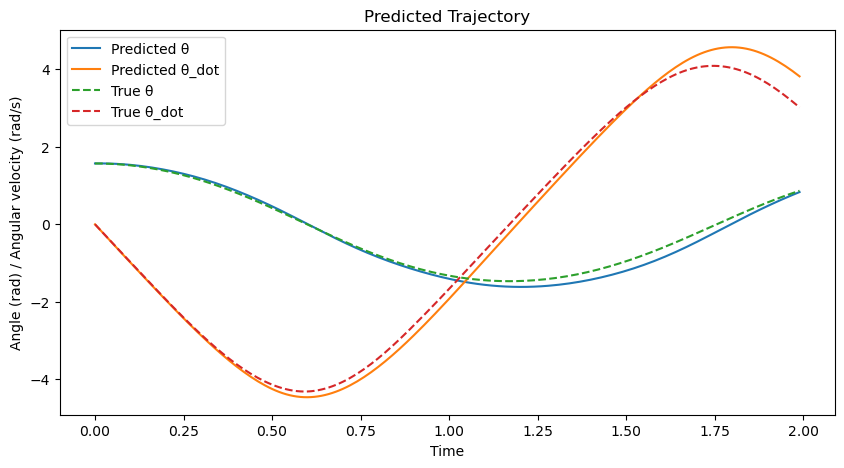

In [32]:
# Load the model and propagate a new trajectory with different initial conditions and longer time
model = torch.load("neural_ode_model_complete.pth").to(device)

# Generate a new trajectory
initial_state = torch.tensor([np.pi/2, 0.0], dtype=torch.float32).to(device)
t_new = torch.arange(0, 2, dt).to(device)
with torch.no_grad():
    pred_trajectory = model(initial_state.unsqueeze(0), t_new, dt)
    pred_trajectory = pred_trajectory.squeeze(0)

from scipy.integrate import solve_ivp
# Generate true trajectory using analytical solution (rk4)
def pendulum_dynamics(t, state, L=1.0, g=9.81, m=1.0, b=0.1):
    theta, theta_dot = state
    theta_ddot = -g/L * np.sin(theta) - b*theta_dot
    return [theta_dot, theta_ddot]

true_trajectory = solve_ivp(pendulum_dynamics, [t_new[0].cpu().numpy(), t_new[-1].cpu().numpy()], initial_state.cpu().numpy(), t_eval=t_new.cpu().numpy(), method="RK45").y.T


# Plot the new trajectory
plt.figure(figsize=(10, 5))
plt.plot(t_new.cpu().detach(), pred_trajectory[:, 0].cpu().detach(), label='Predicted θ')
plt.plot(t_new.cpu().detach(), pred_trajectory[:, 1].cpu().detach(), label='Predicted θ_dot')
plt.plot(t_new.cpu().detach(), true_trajectory[:, 0], '--', label='True θ')
plt.plot(t_new.cpu().detach(), true_trajectory[:, 1], '--', label='True θ_dot')
plt.xlabel('Time')
plt.ylabel('Angle (rad) / Angular velocity (rad/s)')
plt.legend()
plt.title('Predicted Trajectory')
plt.show()
